<a href="https://colab.research.google.com/github/AynaAraujo/Machine_Learning-Listas/blob/main/Lista_2_DT__Ayna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#IMPORTS
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn import tree
import math
import pprint
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix

## Atividade 1

**Agora implemente a classe que corresponde a uma Árvore de decisão**

In [5]:
class DecisionTree:
    def __init__(self, criterion, max_depth, min_samples_split):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Parada
        if depth == self.max_depth or num_samples < self.min_samples_split or num_classes == 1:
            return np.bincount(y).argmax() if y.size > 0 else 0

        # Impureza
        if self.criterion == 'gini':
            impurity_func = self._gini_impurity
        elif self.criterion == 'entropy':
            impurity_func = self._entropy_impurity
        else:
            raise ValueError("Criterio invalido. Use 'gini' ou 'entropy'.")

        #Pega melhor feature e critério
        split_index, threshold = self.split(X, y, impurity_func)

        # Se não tiver um válido escolha a maioria
        if split_index is None or threshold is None:
            return np.bincount(y).argmax()

        # Dividindo data e criando nós
        left_data = X[:, split_index] < threshold
        right_data = X[:, split_index] >= threshold

        left_node = self._build_tree(X[left_data], y[left_data], depth + 1)
        right_node = self._build_tree(X[right_data], y[right_data], depth + 1)

        return {
            "feature": split_index,
            "threshold": threshold,
            "left": left_node,
            "right": right_node
        }


    def split(self, X, y, impurity_func):
        num_features = X.shape[1]
        max_gain = -1
        chosen_feature = None
        chosen_threshold = None

        #Percorre as features
        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])  # Critérios de corte
            for threshold in thresholds:
                # Separa os dados baseado no critério
                left_part = X[:, feature_index] < threshold
                right_part = X[:, feature_index] >= threshold
                #Verifica se teve um lado sem dados
                if sum(left_part) == 0 or sum(right_part) == 0:
                    continue

                # Calculando impurezas
                impurity_before = impurity_func(y)
                impurity_left = impurity_func(y[left_part]) if sum(left_part) > 0 else 0
                impurity_right = impurity_func(y[right_part]) if sum(right_part) > 0 else 0

                # Calculando ganho
                left_gain = sum(left_part) / len(y)
                right_gain = sum(right_part) / len(y)
                gain = impurity_before - (left_gain * impurity_left + right_gain * impurity_right)
                #Vendo qual ganha é maior
                if gain > max_gain:
                    max_gain = gain
                    chosen_feature = feature_index
                    chosen_threshold = threshold

        return chosen_feature, chosen_threshold

    def predict(self, X):
      #Def pra percorrer nos da tree
        def traverse_tree(tree, x):
            if not isinstance(tree, dict):
                return tree
            #Ve se o corte é maior ou menor que a feature e com isso escolhe o lado a percorrer
            if x[tree["feature"]] < tree["threshold"]:
                return traverse_tree(tree["left"], x)
            else:
                return traverse_tree(tree["right"], x)

        return np.array([traverse_tree(self.tree, x) for x in X])

    def _gini_impurity(self, y):
      #verifica se tem classes
        if len(y) == 0:
            return 0
        #Pega amount
        counts = np.bincount(y, minlength=2)
        proportions = counts / counts.sum()
        return 1 - np.sum(proportions ** 2)

    def _entropy_impurity(self, y):
      #verifica se tem classes
        if len(y) == 0:
            return 0
        #Pega amount
        counts = np.bincount(y)
        proportions = counts / len(y)
        return -np.sum([p * math.log2(p) for p in proportions if p > 0])


###Exemplo de Uso

In [ ]:
#PARAMETROS
X = np.array([
    [2.5, 3.0],
    [1.0, 1.5],
    [3.5, 4.0],
    [3.0, 3.5],
    [0.5, 1.0],

])

y = np.array([0, 2, 1, 1, 2])
criterion  = 'gini'
max_depth = 3
min_samples_split = 2


tree = DecisionTree(criterion, max_depth, min_samples_split)
tree.fit(X, y)

# Fazendo previsões
X_test = np.array([
    [2.0, 2.5],
    [3.0, 4.0]
])
predictions = tree.predict(X_test)
print("Previsões:", predictions)


Previsões: [2 1]


## **Atividade 2 - Classificação com o dataset Breast cancer**

Features: Total de 30

Para essa atividade utilizar as features:
1. Mean radius
2. Mean texture
3. Mean perimeter
4. Mean area
5. Mean smoothness

Variável dependente: Presença de câncer de mama maligno ou benigno
1. 0:  Indica que o tumor é maligno (câncer de mama maligno).
2. 1: Indica que o tumor é benigno (câncer de mama benigno).


>**Treine os dados da base breast cancer utilizando o DT implementado**

>**Faça as predições nos dados de teste e compare os dados reais com os preditos**


In [ ]:
data = datasets.load_breast_cancer()
colunas = ['Mean radius', 'Mean texture', 'Mean perimeter', 'Mean area', 'Mean smoothness']
pd.DataFrame(data['data'][:, :5], columns=colunas)

,Mean radius,Mean texture,Mean perimeter,Mean area,Mean smoothness
0,17.99,10.38,122.80,1001.0,0.11840
1,20.57,17.77,132.90,1326.0,0.08474
2,19.69,21.25,130.00,1203.0,0.10960
3,11.42,20.38,77.58,386.1,0.14250
4,20.29,14.34,135.10,1297.0,0.10030
...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100
565,20.13,28.25,131.20,1261.0,0.09780
566,16.60,28.08,108.30,858.1,0.08455
567,20.60,29.33,140.10,1265.0,0.11780


>**As 5 características do dataset Breast cancer possuem escalas diferentes, o que compromete a taxa de acerto. Crie abaixo uma nova classe DecisionTree_Norm para aplicar um algoritmo de normalização de características, refaça o treinamento com as novas classes e analise o impacto no resultado.**

Exemplos de algoritmos de normalização que podem ser utilizados:
1. Normalização Min-Max (Min-Max normalization): Este método dimensiona os dados para que fiquem dentro de um intervalo específico, geralmente entre 0 e 1.

2. Normalização pelo Max: Divide-se cada valor pelo maior valor da amostra. Este método será válido apenas em casos em que os valores forem sempre positivos.

3. Normalização Z-Score: Este método transforma os dados para que tenham uma média zero e um desvio padrão de 1.

In [6]:

#Functions to scale
def scaler_Min_Max(X):
  X = np.array(X)
  #Get de min and max values
  X_min,X_max = X.min(axis=0), X.max(axis=0)
  #Gets the scale
  X_scaled = (X -X_min)/(X_max - X_min)

  return X_scaled


def scaler_Z_score(X):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  return np.array(X_scaled)

>**Divida o dataset em treinamento, teste e validação. Com o conjunto de validação varie os hiperparâmetros do classificador implementado e indique os melhores hiperparâmetros.**

Para a DT pode variar os parâmetros max_depth, min_samples_split, grau de impureza. Como métricas de avaliação podem utilizar recall, precision e f-measure.


In [7]:

class DecisionTree_Norm(DecisionTree):
  def __init__(self, criterion, max_depth, min_samples_split,train_size,test_size,seed):
      super().__init__(criterion, max_depth, min_samples_split)
      self.train_size = train_size
      self.test_size = test_size
      self.seed = seed

  def fit(self,X,y,scaler):
      if scaler == 'Z_score':
        X_scaled = scaler_Z_score(X)
      elif  scaler == 'Min_Max':
        X_scaled = scaler_Min_Max(X)
      else:
        raise Exception('Scaler inválido')
      X_train, X_temp, y_train, y_temp = train_test_split(X_scaled,y,test_size=self.train_size,random_state = self.seed)
      X_val, X_test,y_val, y_test = train_test_split(X_temp,y_temp,test_size=self.test_size,random_state= self.seed)

      self.X_train, self.y_train = X_train, y_train
      self.X_val, self.y_val = X_val, y_val
      self.X_test, self.y_test = X_test, y_test

      super().fit(X_train,y_train)


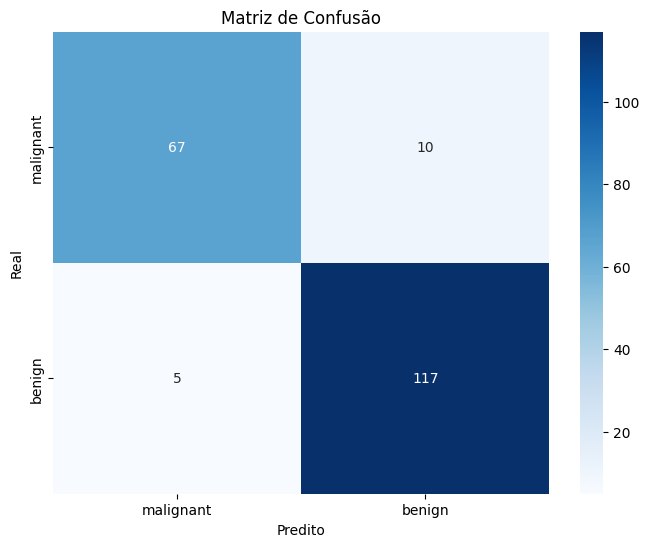


Melhores parâmetros encontrados:
- Min Samples Split: 1
- Max Depth: 4
- Melhor F1-Score: 0.9398


In [ ]:
# Carregar dados
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# Parâmetros
seed = 50
train_size = 0.5
test_size = 0.3
criterion = 'gini'
scaler = 'Z_score'

# Testando hiperparâmetros
min_samples_split = range(1, 10)
max_depth = range(1, 5)

# Listas para armazenar métricas
n_sample_splits = []
depths = []
metrics = []
scores = []
best_params = {"f1_score": 0, "min_samples_split": None, "max_depth": None}

for samples_split in min_samples_split:
    for depth in max_depth:
        tree_norm = DecisionTree_Norm(criterion, depth, samples_split, train_size, test_size, seed)
        tree_norm.fit(X, y, scaler)

        # Fazendo previsões no conjunto de validação
        predictions = tree_norm.predict(tree_norm.X_val)

        # Métricas
        precision = precision_score(tree_norm.y_val, predictions, average='binary')
        recall = recall_score(tree_norm.y_val, predictions, average='binary')
        f1 = f1_score(tree_norm.y_val, predictions, average='binary')

        # Salvando os valores
        for metric_name, score in zip(["Precision", "Recall", "F1-Score"], [precision, recall, f1]):
            n_sample_splits.append(samples_split)
            depths.append(depth)
            metrics.append(metric_name)
            scores.append(score)

        # Atualiza os melhores parâmetros com base no maior F1-Score
        if f1 > best_params["f1_score"]:
            best_params["f1_score"] = f1
            best_params["min_samples_split"] = samples_split
            best_params["max_depth"] = depth

# Criando DataFrame
df = pd.DataFrame({
    'n_sample_split': n_sample_splits,
    'depth': depths,
    'Score': scores,
    'Metric': metrics
})

# Plotando Resultados
fig = px.line(df, x='n_sample_split', y='Score', color='Metric', markers=True,
              title='Precision, Recall e F1-Score vs n_sample_split',
              labels={'n_sample_split': 'Nº Min de Amostras Para Divisão', 'Score': 'Metrics'},
              hover_name='Metric',
              facet_col="depth")  # Plota separado por profundidade
fig.show()

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(tree_norm.y_val, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Exibindo os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(f"- Min Samples Split: {best_params['min_samples_split']}")
print(f"- Max Depth: {best_params['max_depth']}")
print(f"- Melhor F1-Score: {best_params['f1_score']:.4f}")

In [3]:
# Carregar dados
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# Parâmetros
seed = 50
train_size = 0.5
test_size = 0.3
criterion = 'entropy'
scaler = 'Min_Max'

# Testando hiperparâmetros
min_samples_split = range(1, 10)
max_depth = range(1, 5)

# Listas para armazenar métricas
n_sample_splits = []
depths = []
metrics = []
scores = []
best_params = {"f1_score": 0, "min_samples_split": None, "max_depth": None}

for samples_split in min_samples_split:
    for depth in max_depth:
        tree_norm = DecisionTree_Norm(criterion, depth, samples_split, train_size, test_size, seed)
        tree_norm.fit(X, y, scaler)

        # Fazendo previsões no conjunto de validação
        predictions = tree_norm.predict(tree_norm.X_val)

        # Métricas
        precision = precision_score(tree_norm.y_val, predictions, average='binary')
        recall = recall_score(tree_norm.y_val, predictions, average='binary')
        f1 = f1_score(tree_norm.y_val, predictions, average='binary')

        # Salvando os valores
        for metric_name, score in zip(["Precision", "Recall", "F1-Score"], [precision, recall, f1]):
            n_sample_splits.append(samples_split)
            depths.append(depth)
            metrics.append(metric_name)
            scores.append(score)

        # Atualiza os melhores parâmetros com base no maior F1-Score
        if f1 > best_params["f1_score"]:
            best_params["f1_score"] = f1
            best_params["min_samples_split"] = samples_split
            best_params["max_depth"] = depth

# Criando DataFrame
df = pd.DataFrame({
    'n_sample_split': n_sample_splits,
    'depth': depths,
    'Score': scores,
    'Metric': metrics
})

# Plotando Resultados
fig = px.line(df, x='n_sample_split', y='Score', color='Metric', markers=True,
              title='Precision, Recall e F1-Score vs n_sample_split',
              labels={'n_sample_split': 'Nº Min de Amostras Para Divisão', 'Score': 'Metrics'},
              hover_name='Metric',
              facet_col="depth")  # Plota separado por profundidade
fig.show()

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(tree_norm.y_val, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Exibindo os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(f"- Min Samples Split: {best_params['min_samples_split']}")
print(f"- Max Depth: {best_params['max_depth']}")
print(f"- Melhor F1-Score: {best_params['f1_score']:.4f}")


NameError: name 'DecisionTree_Norm' is not defined

Podemos ver que o número min de splits não está afetando, contudo o número de depths sim.

E ao usar gini e Z_score nossas métricas foram melhores.

## **Atividade 3 - Classificação com o dataset Wine**

Features: Total de 13

Para essa atividade utilizar as features:
1. Teor alcoólico
2. Ácido málico
3. Cinzas

Variável dependente: Classe do vinho
1. Classe 0: Vinhos da primeira origem geográfica.
2. Classe 1: Vinhos da segunda origem geográfica.
3. Classe 2: Vinhos da terceira origem geográfica.

**Nesta atividade deverá ser executado o DT, aplicado na base de dados Wine. Separe os dados em conjuntos de treino 70% e teste 30%. Utilize o conjunto de teste para avaliar o desempenho do modelo, calculando métricas como acurácia, recall, precision, f-measure e matriz de confusão. Por fim, visualize a árvore de decisão gerada para entender as decisões que o modelo está tomando e interprete os resultados obtidos.**

In [ ]:
data = datasets.load_wine()
colunas = ['Teor alcoólico', 'Acidez málica', 'Cinzas']
pd.DataFrame(data['data'][:, :3], columns=colunas)

,Teor alcoólico,Acidez málica,Cinzas
0,14.23,1.71,2.43
1,13.20,1.78,2.14
2,13.16,2.36,2.67
3,14.37,1.95,2.50
4,13.24,2.59,2.87
...,...,...,...
173,13.71,5.65,2.45
174,13.40,3.91,2.48
175,13.27,4.28,2.26
176,13.17,2.59,2.37


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


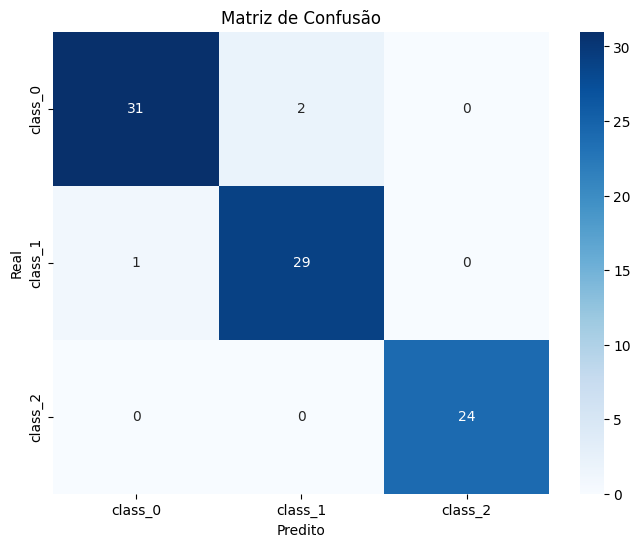


Melhores parâmetros encontrados:
- Max Depth: 3
- Melhor F1-Score: 0.9655


In [8]:
# Carregar dados
data = datasets.load_wine()
X, y = data.data, data.target

# Parâmetros
seed = 50
train_size = 0.7
test_size = 0.3
criterion = 'gini' #Usando esses pois na Atividade 2 foi o que teve melhor f1
scaler = 'Z_score' #Usando esses pois na Atividade 2 foi o que teve melhor f1
min_samples_split = 2

# Testando hiperparâmetros
max_depth = range(1, 10)

# Listas para armazenar métricas
n_sample_splits = []
depths = []
metrics = []
scores = []
best_params = {"f1_score": 0,  "max_depth": None,"depth":0}

for depth in max_depth:
    tree_norm = DecisionTree_Norm(criterion, depth, samples_split, train_size, test_size, seed)
    tree_norm.fit(X, y, scaler)

    # Fazendo previsões no conjunto de validação
    predictions = tree_norm.predict(tree_norm.X_val)

    # Métricas
    precision = precision_score(tree_norm.y_val, predictions, average='weighted')
    recall = recall_score(tree_norm.y_val, predictions, average='weighted')
    f1 = f1_score(tree_norm.y_val, predictions, average='weighted')

    # Salvando os valores
    for metric_name, score in zip(["Precision", "Recall", "F1-Score"], [precision, recall, f1]):
        depths.append(depth)
        metrics.append(metric_name)
        scores.append(score)

    # Atualiza os melhores parâmetros com base no maior F1-Score
    if f1 > best_params["f1_score"]:
        best_params["f1_score"] = f1
        best_params["max_depth"] = depth

# Criando DataFrame
df = pd.DataFrame({
    'depth': depths,
    'Score': scores,
    'Metric': metrics
})

# Plotando Resultados
fig = px.line(df, x='depth', y='Score', color='Metric', markers=True,
              title='Precision, Recall e F1-Score vs Profundidade',
              labels={'depth': 'Profundidade', 'Score': 'Metrics'},
              hover_name='Metric')  # Plota separado por profundidade
fig.show()

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(tree_norm.y_val, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Exibindo os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(f"- Max Depth: {best_params['max_depth']}")
print(f"- Melhor F1-Score: {best_params['f1_score']:.4f}")

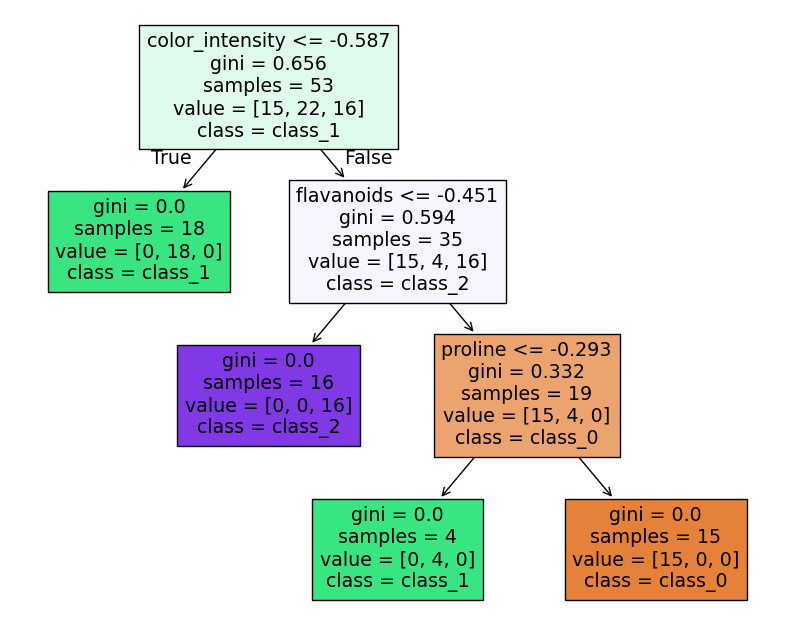

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Usando a biblioteca do sklearn
clf = DecisionTreeClassifier(criterion=tree_norm.criterion,
                             max_depth=tree_norm.max_depth,
                             min_samples_split=tree_norm.min_samples_split,
                             random_state=tree_norm.seed)


clf.fit(tree_norm.X_train, tree_norm.y_train)


plt.figure(figsize=(10, 8))
tree.plot_tree(clf, filled=True, feature_names=data.feature_names, class_names=data.target_names)
plt.show()